In [1]:
# making all imports 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Dense, Activation, Dropout, Reshape, Permute, GRU, BatchNormalization, TimeDistributed

import tensorflow as tf
import keras

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
main_dir = r'C:\Users\dines\Documents\stacked model\archive\chest_xray'
train_data_dir = main_dir + "\\train\\"
validation_data_dir = main_dir + "\\val\\"
test_data_dir = main_dir + "\\test\\"


print("Working Directory Contents:", os.listdir(main_dir))

# creating path is really important when we deal with multiple folder and files 

Working Directory Contents: ['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [3]:
train_n = train_data_dir+'NORMAL\\'
train_p = train_data_dir+'PNEUMONIA\\'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5216
length of pneumonia cases in training set: 3875
length of normal cases in training set: 1341


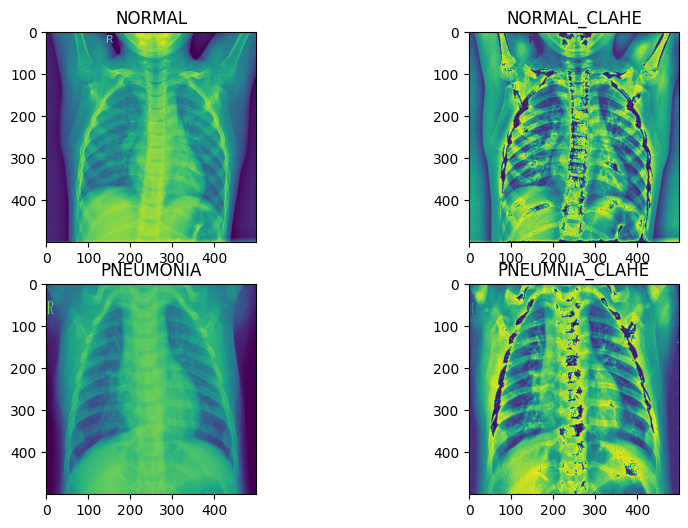

In [4]:
clahe = cv2.createCLAHE(clipLimit = 5)


img_name = 'IM-0115-0001.jpeg'
img_normal = cv2.imread(r'C:\\Users\\dines\\Documents\\stacked model\\archive\\chest_xray\\train\\NORMAL\\' + img_name)
img_normal = cv2.resize(img_normal, (500,500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal) + 30



img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = cv2.imread(r'C:\\Users\\dines\\Documents\\stacked model\\archive\\chest_xray\\train\\PNEUMONIA\\' + img_name_1)
img_pneumonia = cv2.resize(img_pneumonia, (500,500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia) + 30


#-----------------------------------------------------------------------------------------#


fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE");


In [5]:
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 625 images belonging to 3 classes.


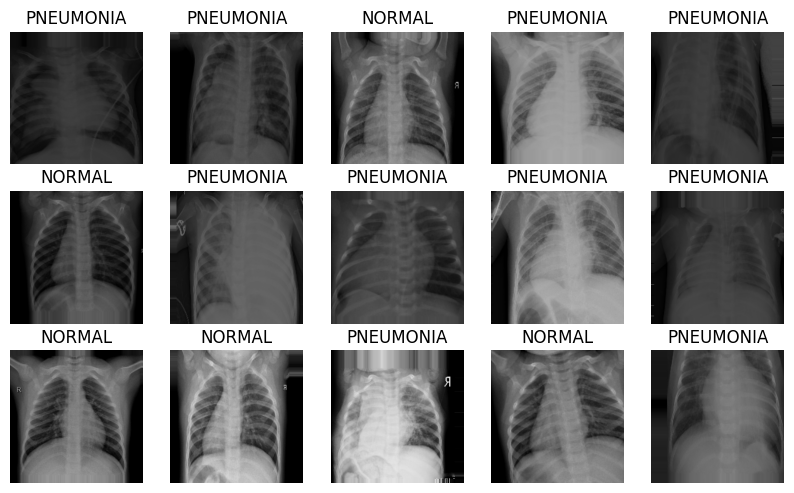

In [6]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [7]:
nb_train_samples = 5216 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 20  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches for training)

In [8]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False # freezing densenet layers 

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))

densenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

In [9]:
# defined optimizer
optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=7,
                              verbose=1,
                              mode='max',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [10]:
### Training our model
dense_history = densenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr]) 

Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7467
Epoch 1: val_loss improved from inf to 0.35162, saving model to .\densenet169.h5
326/326 [==============================] - 84s 222ms/step - loss: 0.5252 - accuracy: 0.7467 - val_loss: 0.3516 - val_accuracy: 0.8592 - lr: 1.0000e-04
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8660
Epoch 2: val_loss improved from 0.35162 to 0.29827, saving model to .\densenet169.h5
326/326 [==============================] - 69s 212ms/step - loss: 0.3195 - accuracy: 0.8660 - val_loss: 0.2983 - val_accuracy: 0.8816 - lr: 1.0000e-04
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.8955
Epoch 3: val_loss improved from 0.29827 to 0.29146, saving model to .\densenet169.h5
326/326 [==============================] - 84s 256ms/step - loss: 0.2649 - accuracy: 0.8955 - val_loss: 0.2915 - val_accuracy: 0.8896 - lr: 1.0000e-04
Epoch 4/

In [11]:
# its always a good practice to load the model after saving with the best epochs 
densenet_model = keras.models.load_model('./densenet169.h5')

In [12]:
# for plotting learning curve 
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image


def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')


In [14]:
# for evaluation point of view i have created a dataframe of test directory 
test_data = []
test_normal_path = test_data_dir + '/NORMAL'
test_pneumonia_path = test_data_dir + '/PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    
    
    
    
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)
# this test_df must contain the img_path and label column in order to run the function   

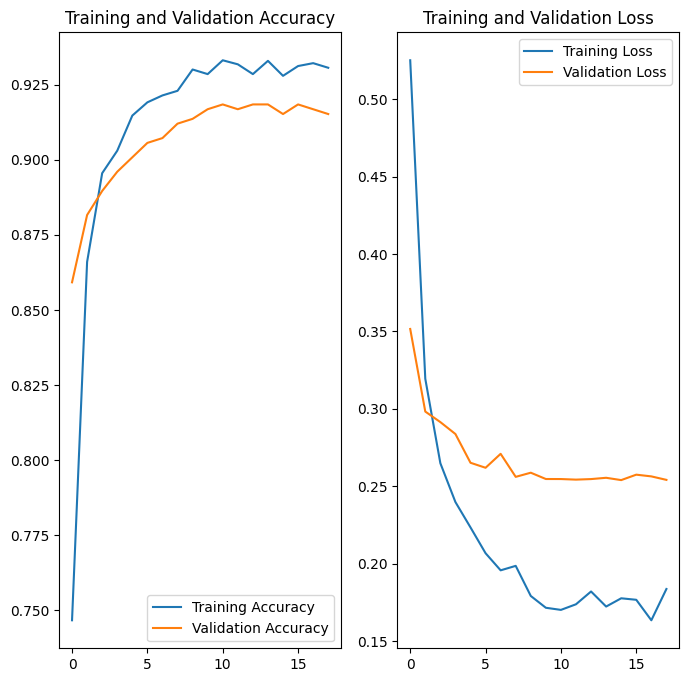

In [15]:
plot(dense_history)

In [16]:
densenet_model = keras.models.load_model('./densenet169.h5')

1/1 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



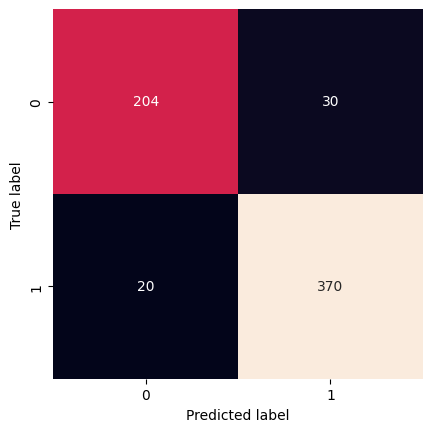

In [17]:
testing(densenet_model, test_df)

In [18]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape= (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(1, activation='sigmoid'))

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [19]:
# defined optimizer
optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.001,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=4,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./mobilenet.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


### Training our model
mobilenet_history = mobilenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.6929
Epoch 1: val_loss improved from inf to 0.34943, saving model to .\mobilenet.h5
326/326 [==============================] - 66s 195ms/step - loss: 0.6344 - accuracy: 0.6929 - val_loss: 0.3494 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.34943 to 0.25868, saving model to .\mobilenet.h5
326/326 [==============================] - 65s 201ms/step - loss: 0.3708 - accuracy: 0.8334 - val_loss: 0.2587 - val_accuracy: 0.8992 - lr: 1.0000e-04
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8775
Epoch 3: val_loss improved from 0.25868 to 0.23328, saving model to .\mobilenet.h5
326/326 [==============================] - 63s 194ms/step - loss: 0.2933 - accuracy: 0.8775 - val_loss: 0.2333 - val_accuracy: 0.9072 - lr: 1.0000e-04
Epoch 4/20
326

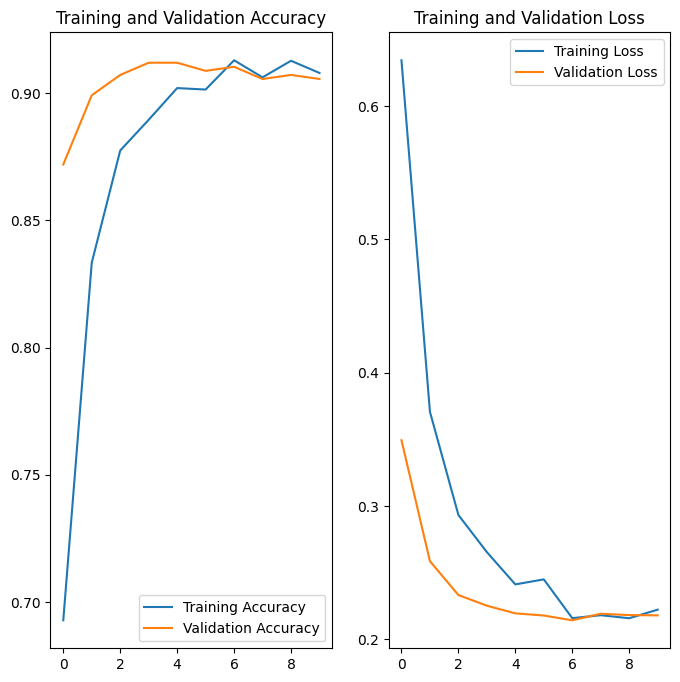

In [20]:
plot(mobilenet_history)

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       234
           1       0.95      0.90      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



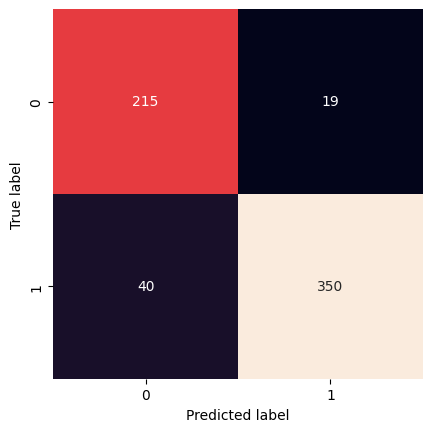

In [21]:
testing(mobilenet_model, test_df)

In [22]:
from tensorflow.keras.applications import Xception
base = Xception(weights = 'imagenet', include_top = False, input_shape= (224, 224, 3))
tf.keras.backend.clear_session()
for layer in base.layers:
    layer.trainable =  False # freezing densenet layers 

xception_model = Sequential()
xception_model.add(base)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(BatchNormalization())
xception_model.add(Dense(256, activation='relu'))
xception_model.add(Dropout(0.5))
xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dropout(0.5))
xception_model.add(Dense(1, activation='sigmoid'))

xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [23]:
# defined optimizer
optm = Adam(lr=0.0001)
xception_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])
# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=7,
                              verbose=1,
                              mode='max',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./xception.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

### Training our model
xception_history = xception_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr]) 


Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8138
Epoch 1: val_loss improved from inf to 0.38940, saving model to .\xception.h5
326/326 [==============================] - 76s 226ms/step - loss: 0.4139 - accuracy: 0.8138 - val_loss: 0.3894 - val_accuracy: 0.8128 - lr: 1.0000e-04
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8900
Epoch 2: val_loss improved from 0.38940 to 0.33022, saving model to .\xception.h5
326/326 [==============================] - 69s 210ms/step - loss: 0.2786 - accuracy: 0.8900 - val_loss: 0.3302 - val_accuracy: 0.8432 - lr: 1.0000e-04
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9003
Epoch 3: val_loss improved from 0.33022 to 0.32101, saving model to .\xception.h5
326/326 [==============================] - 64s 198ms/step - loss: 0.2455 - accuracy: 0.9003 - val_loss: 0.3210 - val_accuracy: 0.8688 - lr: 1.0000e-04
Epoch 4/20
326/32

In [24]:
tf.keras.utils.disable_interactive_logging()

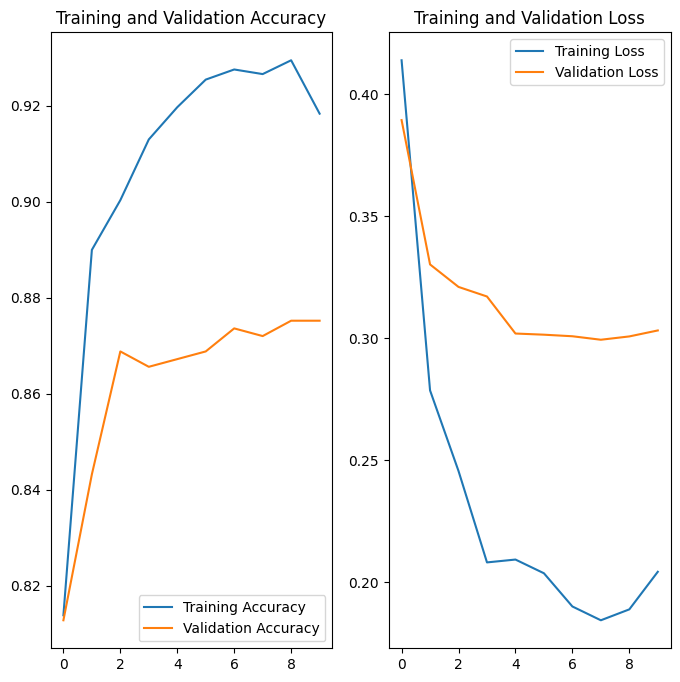

In [25]:
plot(xception_history)

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       234
           1       0.88      0.93      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



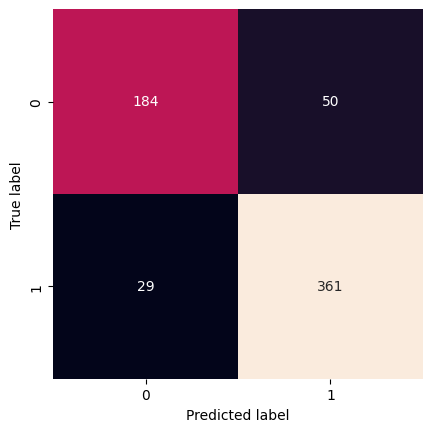

In [26]:
testing(xception_model, test_df)

In [27]:
from tensorflow.keras.layers import concatenate
from keras.layers import Input
import tensorflow as tf

input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))

#first model
base_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_densenet = DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_xception = Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)


for layer in base_mobilenet.layers:
    layer.trainable =  False
for layer in base_densenet.layers:
    layer.trainable = False
for layer in base_xception.layers:
    layer.trainable = False
    
model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

model_xception = base_xception(input_layer)
model_xception = GlobalAveragePooling2D()(model_xception)
output_xception = Flatten()(model_xception)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet, output_xception]) 

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)


In [28]:
stacked_model.summary()

In [29]:
# defined optimizer
optm = Adam(lr=0.0001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


### Training our model
stacked_history = stacked_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,                    
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

In [30]:
stacked_model = keras.models.load_model('./stacked_model.h5')

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       234
           1       0.93      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



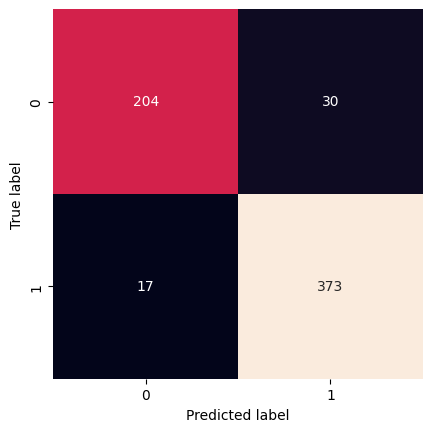

In [31]:
testing(stacked_model,test_df)

In [32]:
#### Lets do some prediction on our validation data 
# for evaluation point of view i have created a dataframe of test directory 
validation_data = []
validation_normal_path = validation_data_dir + '/NORMAL'
validation_pneumonia_path = validation_data_dir + '/PNEUMONIA'
for filename in os.listdir(validation_normal_path):
    validation_data.append((os.path.join(validation_normal_path,filename),0))
for filename in os.listdir(validation_pneumonia_path):
    validation_data.append((os.path.join(validation_pneumonia_path,filename),1))    

In [33]:
validation_df = pd.DataFrame(validation_data, columns = ['img_path','label'], index = None)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

In [34]:
validation_df.head()

,img_path,label
0,C:\Users\dines\Documents\stacked model\archive...,1
1,C:\Users\dines\Documents\stacked model\archive...,1
2,C:\Users\dines\Documents\stacked model\archive...,0
3,C:\Users\dines\Documents\stacked model\archive...,1
4,C:\Users\dines\Documents\stacked model\archive...,1


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



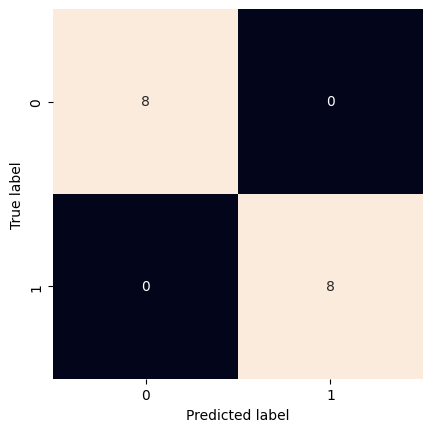

In [35]:
testing(stacked_model, validation_df)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



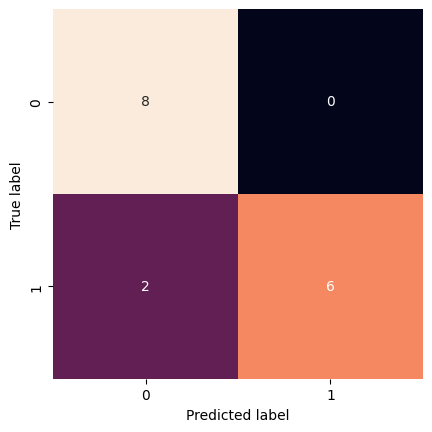

In [36]:
testing(mobilenet_model, validation_df)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



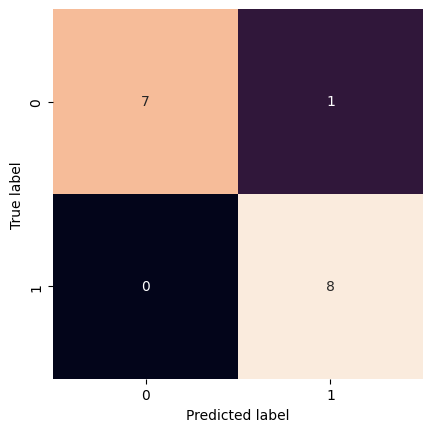

In [37]:
testing(densenet_model, validation_df)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



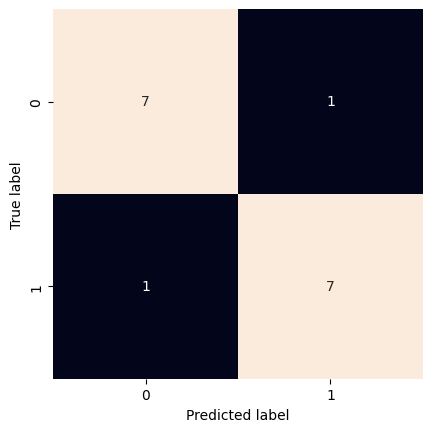

In [38]:
testing(xception_model, validation_df)

In [39]:
def predict_image(validation_df, model):
    plt.figure(figsize=(6,6))
    for index , data in validation_df[:10].iterrows():
        img_name = data['img_path']
        label = data['label']
    
        label_predicted = np.where((predict(img_name , model)[0][0])>0.5,'pneumonia','normal')
        plt.imshow(load_img(img_name, target_size = (120,120)))
        if label == 1:
            plt.xlabel(f"True:Pneumonia, Predicted:{label_predicted}", fontsize = 15)
        if label == 0:
            plt.xlabel(f"True:Normal, Predicted:{label_predicted}", fontsize = 15)
            
        plt.tight_layout()
        plt.show()
    

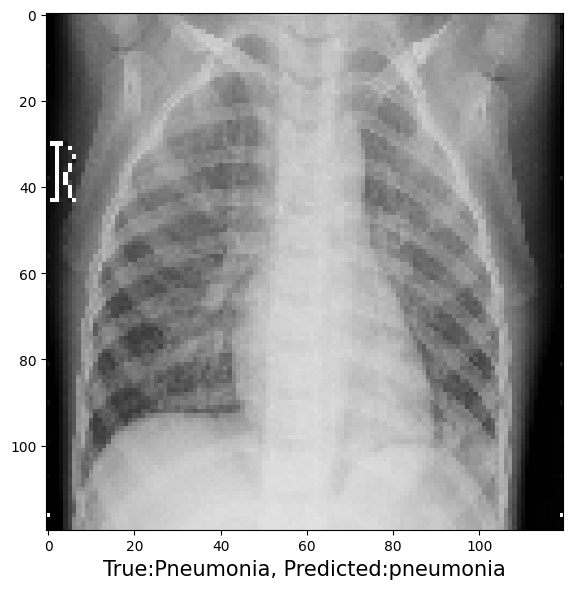

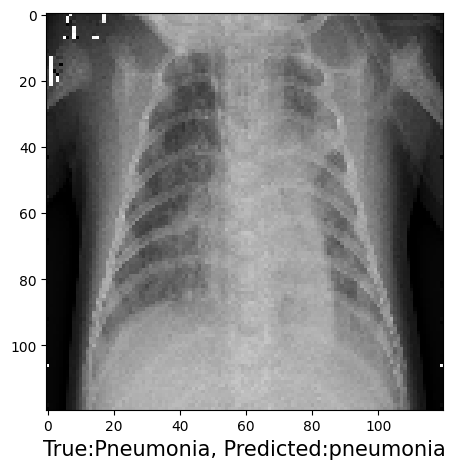

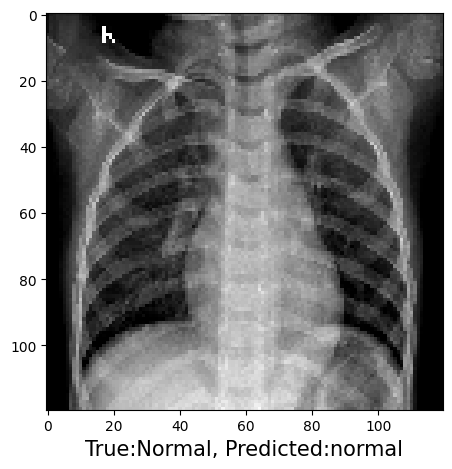

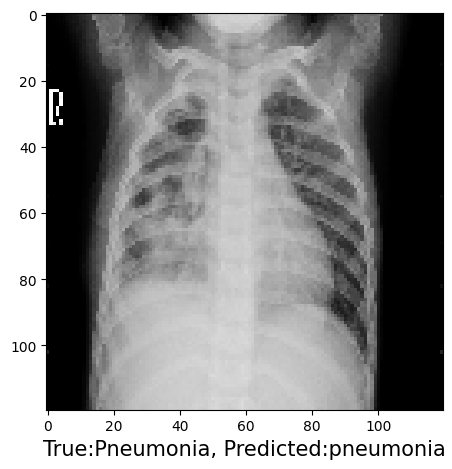

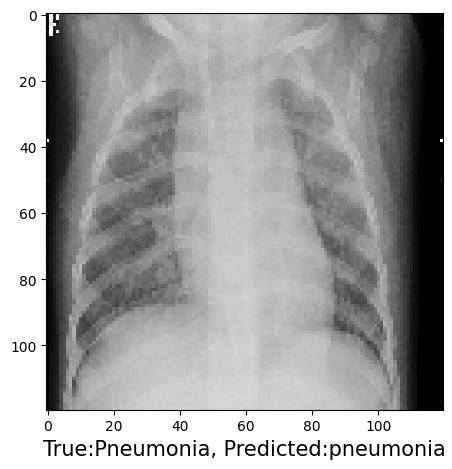

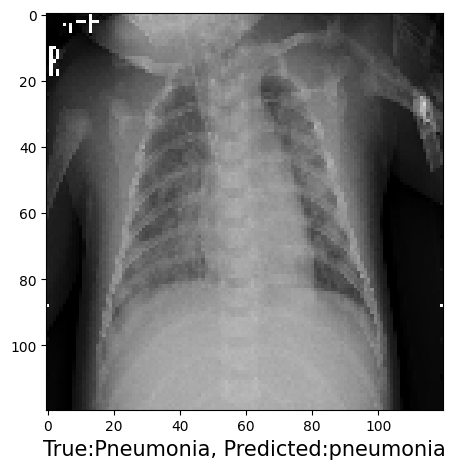

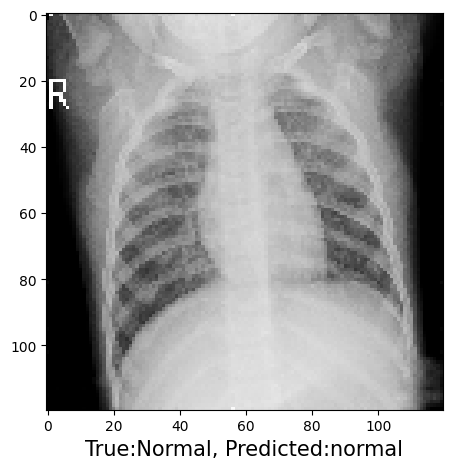

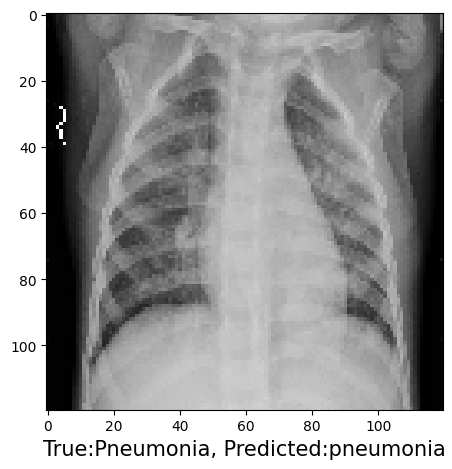

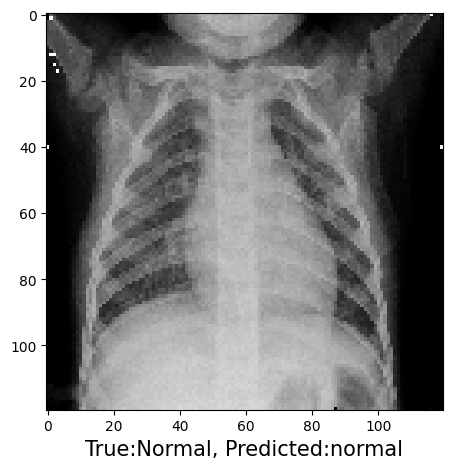

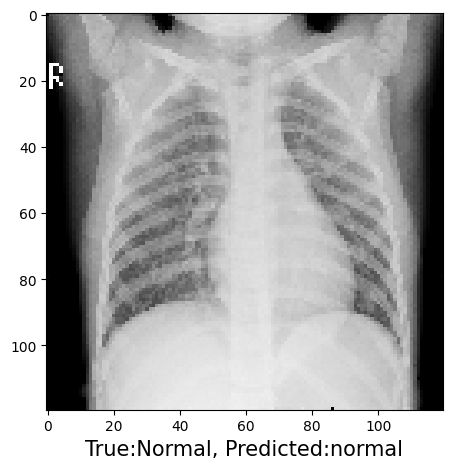

In [40]:
predict_image(validation_df, )